In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt# Noise block
import numpy as np
sns.set()
%matplotlib inline
import time
import pickle

import plotly.graph_objects as go
from collections import defaultdict, Counter
import matplotlib.colors as mcolors

from sklearn.metrics import silhouette_samples, silhouette_score, accuracy_score, recall_score
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, MiniBatchKMeans, Birch
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import normalize
from scipy.sparse import *
from sklearn.model_selection import train_test_split
import gensim
import sklearn
import shap
import xgboost
import matplotlib.cm as cm

from itertools import permutations, cycle, islice
import torch
torch.manual_seed(10)
from torch.utils.data import DataLoader, Dataset, IterableDataset
import torch.nn as nn
import torch.optim as optim
import os

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from interpret import show
from interpret.perf import ROC
from interpret.glassbox import ExplainableBoostingClassifier, LogisticRegression, ClassificationTree, DecisionListClassifier
from interpret.blackbox import ShapKernel
from interpret.data import ClassHistogram

unable to import 'smart_open.gcs', disabling that module


In [2]:
class Product():
    def __init__(self, row, prices, index):
        self.usages = 0
        self.hierarchy_indices = []
        self.index = index
        if DATASET == 'strauss':
            self.barcode = str(row[0])
            self.hierarchy_names = [str(i//2)+'_'+row[1][i] for i in [1,3,5,7]] + [self.barcode]
            self.price = min(prices.get(self.barcode, 10),100)
            self.name = str(row[1][0])
        else:
            row = row[1]
            self.barcode = str(row[0])
            self.hierarchy_names = [str(j)+'_'+row[i] for j,i in enumerate([2,4,5])] + [self.barcode]
            self.price = min(prices[self.barcode],50)
            self.name = str(row[0])
        
class Transaction():
    def __init__(self, t_id, u_id, total=0):
        self.id = t_id
        self.user_id = u_id
        #self.barcodes = []
        self.indices = []
        #self.quantities = []
        #self.prices = []
        self.total = total # only for strauss dataset
        self._test_index = -1
        self.test_item = None
    
    def create_test_item(self): # need to refactor this function.
        if len(self.indices) > 10:
            index = np.random.randint(0, len(self.indices))
            self.test_item = (self.indices.pop(index))#, self.quantities.pop(index),  self.prices.pop(index))
            self._test_index = index
    
    def return_test_item(self):
        if self._test_index != -1:
            index = self._test_index
            #self.barcodes.insert(self.test_item[0], index)
            self.indices.insert(self.test_item[0], index)
            #self.quantities.insert(self.test_item[1], index)
            #self.prices.insert(self.test_item[2], index)
            self._test_index = -1
            self.test_item = None


In [3]:

DATASET = 'dunnhumby'
backup_path = './data.pkl' if DATASET != 'strauss' else 'Q:/data.pkl'
embedding_path = 'gensim.w2v' if DATASET != 'strauss' else 'Q:/gensim.w2v'
clustering_path = 'clustering.pkl' if DATASET != 'strauss' else 'Q://clustering.pkl'

# To create please use data_loader notebook, attached to this one
Resulting objects: 
<ul>
    <li> <b>transactions</b> # list {Transaction object}</li>
    <li> <b>products</b> # dict {barcode: Product object}</li>
    <li> <b>GROUP_INDEX_OF</b> # Dict [name of hierarchy group/barcode: relative index in relevant hierarchy level]</li>
    <li> <b>INDEX_OF</b> # Dict {name of hierarchy group/barcode: absolute index in concatenated vector}</li>
    <li> <b>NEGATIVE_SAMPLING_PROBABILITY, DOWNSAMPLE_PROBABILITY</b> # Dicts barcode: probability</li>
    <li> <b>LEVEL_SIZE, DEPTH</b> # Properties of hierarchy</li>
</ul>

In [4]:

if not os.path.exists(backup_path):
    print('please use data_loader notebook')
else:
    with open(backup_path, 'rb') as f:
        transactions, products, GROUP_INDEX_OF, INDEX_OF, NEGATIVE_SAMPLING_PROBABILITY, DOWNSAMPLE_PROBABILITY, LEVEL_SIZE, DEPTH = pickle.load(f)

In [5]:
del transactions

In [6]:
if not os.path.exists(embedding_path):
    dataset = [[str(y) for y in x.indices] for x in transactions if len(x.indices) > 1]
    gensim_skipgram = gensim.models.Word2Vec(dataset, window=100, min_count=1, workers=12,sg=1, min_alpha=0.01, iter=10,compute_loss=True, )
    gensim_embeddings = np.vstack([gensim_skipgram.wv.get(str(i), np.zeros(100)) for i in range(len(products))])
    with open(embedding_path, 'wb') as f:
        pickle.dump(gensim_embeddings, f)
with open(embedding_path, 'rb') as f:
    gensim_embeddings = pickle.load(f)

In [7]:
LOAD_VECS = True
if LOAD_VECS:
    with open(clustering_path, 'rb') as f:
        X_embeddings, tf_matrix = pickle.load(f)
else:
    print('please use vector_bulding notebook')
#small_vectors = {k: vectors[k] for k in sorted(list(vectors.keys()))[:10000]}
#small_price_vectors = {k: price_vectors[k] for k in sorted(list(price_vectors.keys()))[:10000]}

X_embeddings_normalized = normalize(X_embeddings, axis=1)
tf_normalized = normalize(tf_matrix, axis=1)

In [8]:
def viz_silhoette(X, clf, title='', ax=None, cluster_labels=None):
    if cluster_labels is None:
        cluster_labels = clf.predict(X)
    n_clusters = len(set(cluster_labels))
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    #clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    if ax is None:
        f, ax1 = plt.subplots(1,1, figsize=(8,5))
    else:
        ax1 = ax
    ax1.set_ylim([0, X.shape[0] + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title(title)
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=np.mean(sample_silhouette_values), color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    
    ax1.set_xlim([-0.2, 1])
    _ = ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    if ax is None:
        plt.show()

MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=1


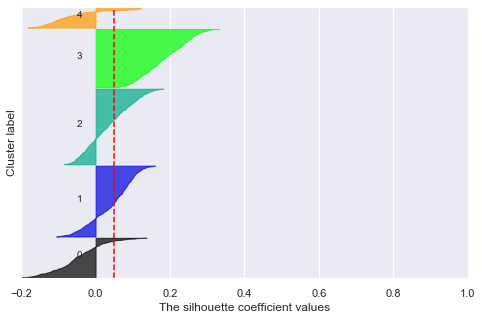

In [9]:
clf = MiniBatchKMeans(n_clusters=5, random_state=2)
#clf = GaussianMixture(n_components=10, random_state=3)
clf.fit(X_embeddings_normalized)
viz_silhoette(X_embeddings_normalized, clf)
y = clf.predict(X_embeddings_normalized)

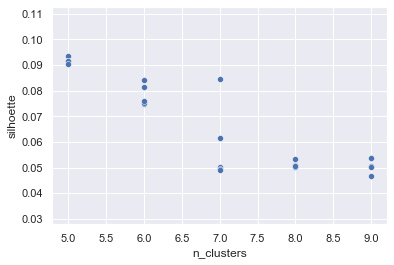

In [46]:
res = []
for k in range(5,10):
    for i in range(5):
        clf = KMeans(n_clusters=k, random_state=i)
    #clf = GaussianMixture(n_components=10, random_state=3)
        clf.fit(X_embeddings_normalized)
        y = clf.predict(X_embeddings_normalized)
        res.append([k, silhouette_score(X_embeddings_normalized, y)])
sns.scatterplot(x='n_clusters', y='silhoette', data=pd.DataFrame(data=res, columns=['n_clusters', 'silhoette']))

In [93]:
offset = sum(LEVEL_SIZE[:-2])
feature_names = [x[2:].replace('[', ')').replace(']', ')').replace('<', ' ') for x in list(INDEX_OF.keys())[offset:tf_normalized.shape[1]]]
df = pd.DataFrame(data=normalize(tf_normalized[:, offset:], axis=1), columns=feature_names)
#

from sklearn.utils import resample
def split(cluster, np_array=False):
    X_train, X_test, y_train, y_test = train_test_split(df, [z==cluster for z in y], test_size=0.20, random_state=1)
    if X_train.shape[0] > sum(y_train)*4:
        z_df = X_train[[not x for x in y_train]]
        z_df = resample(z_df, n_samples=sum(y_train)*3, random_state=1)
        X_train = X_train[y_train].append(z_df)
        y_train = np.array([1]*(len(X_train) - len(z_df)) +[0]*len(z_df))
    # for the tests
    X_train, _, y_train, _ = train_test_split(X_train, y_train, test_size=0.8, random_state=1)
    if np_array:
        return X_train.values, X_test.values, y_train, y_test
    return X_train, X_test, y_train, y_test

def viz_explanation(cluster=0):
    X_train, X_test, y_train, y_test = split(cluster)
    hist = ClassHistogram().explain_data(X_train, y_train, name = 'Train Data')

    ebm = ExplainableBoostingClassifier(random_state=1, n_jobs=8, interactions=0, max_bins=30)
    ebm.fit(X_train, y_train)   #Works on dataframes and numpy arrays
    ebm_global = ebm.explain_global(name='EBM')
    ebm_local = ebm.explain_local(X_test[y_test][:5].append(X_test[y_test].mean(), ignore_index=True), [1]*6, name='EBM')
    ebm_perf = ROC(ebm.predict_proba).explain_perf(X_test, y_test, name='EBM')
    lr = LogisticRegression(random_state=1, feature_names=feature_names, penalty='l1', solver='liblinear', C=1)
    lr.fit(X_train, y_train)
    #sorted(zip(lr.sk_model_.coef_[0], feature_names), key=lambda x: x[0], reverse=True)[:10]
    lr_perf = ROC(lr.predict_proba).explain_perf(X_test, y_test, name='Logistic Regression')

    lr_global = lr.explain_global(name='Logistic Regression')
    
    
    show([hist, lr_global, lr_perf, ebm_global, ebm_perf, ebm_local], share_tables=True)

def viz_shap(cluster=0):
    X_train, X_test, y_train, y_test = split(cluster, True)
    model = xgboost.XGBClassifier(use_label_encoder=False) 
    #model = sklearn.linear_model.LogisticRegression(max_iter=100, penalty='l1', solver='liblinear')
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print(cluster, accuracy_score(y_test, predictions), recall_score(y_test, predictions))
    X_train.columns = [x[::-1] for x in feature_names] if DATASET == 'strauss' else feature_names
    explainer = shap.Explainer(model, X_train)
    shap.initjs()
    shap_values = explainer(X_train)
    shap.summary_plot(shap_values, X_train)
    
def viz_lr(cluster=0, viz_center=False, k=20):
    X_train, X_test, y_train, y_test = split(cluster, True)
    model = sklearn.linear_model.LogisticRegression(max_iter=100, penalty='l1', solver='liblinear')
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print(accuracy_score(y_test, predictions), recall_score(y_test,predictions))
    if viz_center:
        weights = X_train[y_train].mean(axis=0)*model.coef_[0]
    else:
        weights = model.coef_[0]
    named_coef = list(zip(weights, feature_names))
    tmp = pd.DataFrame(sorted(named_coef, key=lambda x: x[0], reverse=True), columns=['Logistic regression weight', 'sub-category'])
    return tmp.head(k//2).append(tmp.tail(k//2))

def create_lists(cluster=0):
    X_train, X_test, y_train, y_test = split(cluster)
    cluster_center = X_train.iloc[y_train].mean(axis=0)
    
    #ebm = ExplainableBoostingClassifier(random_state=1, n_jobs=8, interactions=0, max_bins=30)
    #ebm.fit(X_train, y_train)
    #ebm_list = []
    
    model = xgboost.XGBClassifier(use_label_encoder=False) 
    model.fit(X_train, y_train)
    explainer = shap.TreeExplainer(model, X_train)
    shap_values = explainer(X_train.append(cluster_center, ignore_index=True))
    shap_aggregated = shap_values[:-1,:][y_train,:].mean(axis=0).values
    
    shap_center = shap_values[-1,:]
    
    lr = sklearn.linear_model.LogisticRegression(max_iter=100, penalty='l1', solver='liblinear', C=10)
    lr.fit(X_train, y_train)
    lr_prediction = X_train.values[y_train].mean(axis=0)*lr.coef_[0]
    lr_weights = lr.coef_[0]
    
    return shap_aggregated, shap_center.values, lr_prediction, lr_weights


In [96]:
def rank_to_score(rank, l):
    return len(l)-rank-1

def aggregate_lists(lists, method='rank'):
    if method == 'score':
        stacked_scores = np.stack(lists).T
        norm_scores = sklearn.preprocessing.StandardScaler().fit_transform(stacked_scores)
        new_scores = norm_scores.mean(1)
        return new_scores
    
    scores = np.zeros(len(lists[0]))
    for l in lists:
        list_scores = Counter(np.abs(l))
        less_than = {sc: sum([v for k,v in list_scores.items() if k < sc ]) for sc in list_scores.keys()}
        for i, v in enumerate(np.abs(l)):
            scores[i] += less_than[v]
            
    for i in range(len(lists[0])):
        if all(l[i] >= 0 for l in lists):
            continue
        elif all(l[i] <= 0 for l in lists):
            scores[i] = -scores[i]
        else:
            scores[i]=0
    return scores

def top_k_features(scores, k=20, positive=15):
    best = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)
    best = [(feature_names[i], scores[i]) for i in best]
    return best[:positive] + best[-(k-positive):]


In [97]:
r = create_lists(3)
top_k_features(aggregate_lists(r, method='score'))

[('DAIRY CASE FRUIT DRINKS (NO JU', 13.756396154207811),
 ('SOFT DRINK POWDER POUCHES', 7.66105748098232),
 ('MAINSTREAM WHITE BREAD', 7.577764328176729),
 ('KIDS CEREAL', 5.236194785487074),
 ('SUGAR', 4.7613511000722655),
 ('RICE SIDE DISH MIXES DRY', 3.37730697902177),
 ('PICKLES', 3.192538531802756),
 ('FLUID MILK WHITE ONLY', 3.1651301911968908),
 ('SOFT DRINKS 12/18&15PK CAN CAR', 3.103994095953198),
 ('JELLY', 2.651772352344241),
 ('SOFT DRINKS CAN NON-CARB (EXCE', 2.551781706322161),
 ('MACARONI & CHEESE DNRS', 2.4936335527288787),
 ('CANDY BARS (SINGLES)(INCLUDING', 2.0974309082919333),
 ('FRZN BREADED PREPARED CHICK', 1.7696100740511442),
 ('HAIR CONDITIONERS AND RINSES', 1.7481882326312403),
 ('PREMIUM', -5.1956196956846865),
 ('SHREDDED CHEESE', -5.278802593135269),
 ('FACIAL TISSUE & PAPER HANDKE', -5.431330424681868),
 ('SS ECONOMY ENTREES/DINNERS ALL', -5.7926449192547205),
 ('BABY FOOD JUNIOR ALL BRANDS', -7.757548931199285)]

In [98]:
top_k_features(aggregate_lists(r, method='rank'))

[('SOFT DRINK POWDER POUCHES', 7135.0),
 ('MAINSTREAM WHITE BREAD', 7103.0),
 ('KIDS CEREAL', 7101.0),
 ('DAIRY CASE FRUIT DRINKS (NO JU', 3596.0),
 ('PICKLES', 3585.0),
 ('JELLY', 3577.0),
 ('SOFT DRINKS CAN NON-CARB (EXCE', 3576.0),
 ('MACARONI & CHEESE DNRS', 3558.0),
 ('HAIR CONDITIONERS AND RINSES', 3555.0),
 ('FRZN BREADED PREPARED CHICK', 3551.0),
 ('FLUID MILK WHITE ONLY', 3546.0),
 ('DAIRY CASE JUICE DRNK UNDER 10', 3544.0),
 ('TOOTHPASTE', 3520.0),
 ('SANDWICHES&HANDHELDS', 3518.0),
 ('SPICES & SEASONINGS', 3516.0),
 ('LIQUID LAUNDRY DETERGENTS', -7084.0),
 ('PAPER TOWELS & HOLDERS', -7090.0),
 ('PRETZELS', -7109.0),
 ('SPRING WATER', -7119.0),
 ('FACIAL TISSUE & PAPER HANDKE', -7154.0)]

In [92]:
viz_explanation(0)
#viz_explanation(1)
#viz_explanation(2)
#viz_explanation(3)

INFO:interpret.visual.udash:Generated full dash


<!-- http://127.0.0.1:7001/2096403782856/ -->
 Open in new window

INFO:interpret.visual.udash:No df provided in pane cb for model idx: 2


3 0.9327146171693735 0.801980198019802


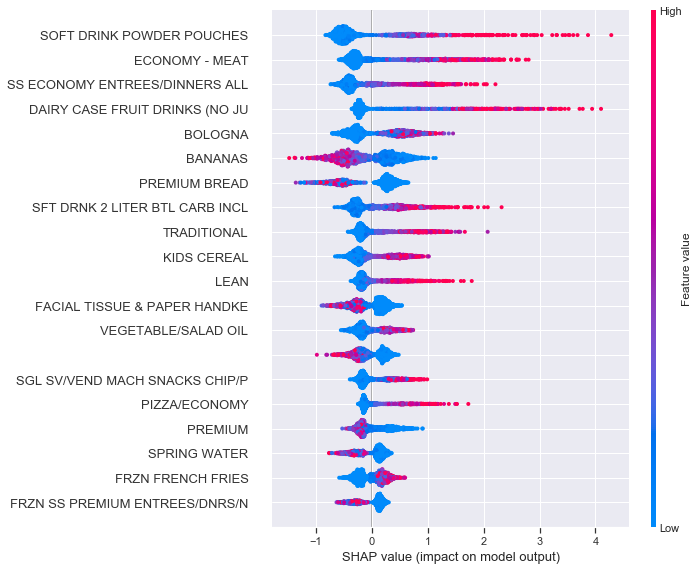

In [30]:
viz_shap(3)
#viz_shap(1)
#viz_shap(2)

In [38]:
viz_lr(3)

0.9164733178654292 0.7623762376237624


,Logistic regression weight,sub-category
0,12.700227,ECONOMY - MEAT
1,7.368924,DAIRY CASE FRUIT DRINKS (NO JU
2,5.994087,LEAN
3,4.973659,KIDS CEREAL
4,4.715227,BOLOGNA
5,4.613741,SS ECONOMY ENTREES/DINNERS ALL
6,4.348308,SOFT DRINK POWDER POUCHES
7,4.023175,PIZZA/ECONOMY
8,3.738165,VEGETABLE/SALAD OIL
9,3.507102,TRADITIONAL


In [32]:
from lime.lime_tabular import LimeTabularExplainer
X_train, X_test, y_train, y_test = train_test_split(df.values, [z==3 for z in y], test_size=0.20, random_state=1)

explainer = LimeTabularExplainer(training_data=X_train, mode='classification', training_labels=y_train, feature_names=feature_names)

In [33]:
exp = explainer.explain_instance(X_train[y_train].mean(axis=0), model.predict_proba, num_features=20, labels=(1,))

In [34]:
exp.show_in_notebook()

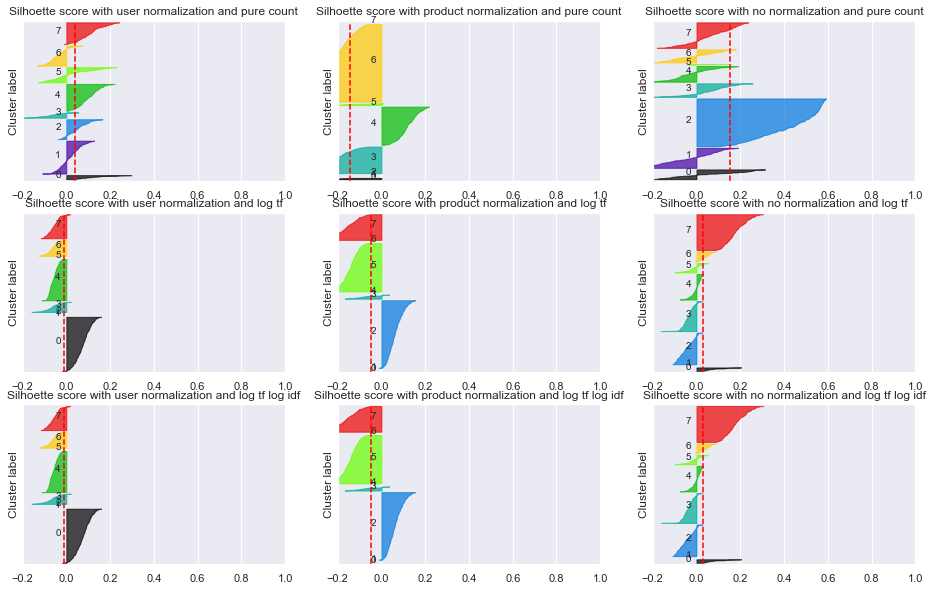

In [25]:
f, ax = plt.subplots(3, 3, figsize=(16,10))
for i in range(3):
    idf_function=log_idf if i==3 else None
    tf_function=None if i==0 else log_tf
    title = 'pure count' if i==0 else ('log tf' if i==1 else 'log tf log idf')
    
    for j in range(3):
        norm = 'user' if j==0 else ('product' if j==1 else 'no')
        X, i_t_n, clf, importance_matrix = run_experiment({k: vectors[k] for k in list(vectors.keys())[:1000]}, [1,2,3], n_clusters=8, idf_function=idf_function, tf_function=tf_function, norm=norm)
        viz_silhoette(X, clf, 8, ax=ax[i][j])
        ax[i][j].set_title('Silhoette score with {} normalization and {}'.format(norm, title))
        ax[i][j].set_xlabel('')

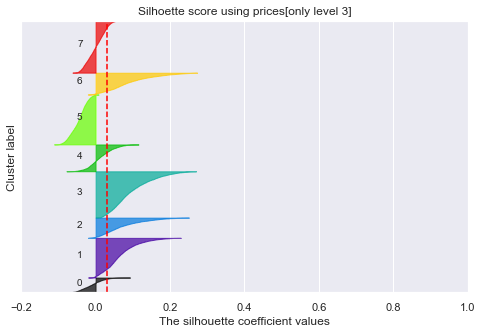

cluster 1
coverage 0.3045626947112419


cluster 4
coverage 0.2624018828638362


Average user
coverage 0.2692485462586257


Average user(50 features)
coverage 0.3538255584109336


In [58]:

X, i_t_n, clf, importance_matrix = run_experiment(price_vectors, [3], n_clusters=8, norm='user', tf_function=None, idf_function=None)
viz_silhoette(X, clf, 8, title='Silhoette score using prices[only level 3]')
viz_clustering(X, i_t_n, clf)

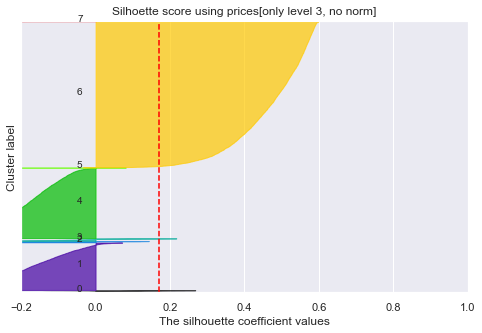

In [62]:

X_small_price, i_t_n, clf, importance_matrix = run_experiment(small_price_vectors, [3], n_clusters=8, norm='no', tf_function=None, idf_function=None)
viz_silhoette(X_small_price, clf, 8, title='Silhoette score using prices[only level 3, no norm]')

In [55]:
X_small_price, i_t_n, clf, importance_matrix = run_experiment(small_price_vectors, [3], n_clusters=8, norm='user', tf_function=None, idf_function=None)
X_small, i_t_n, clf, importance_matrix = run_experiment(small_vectors, [3], n_clusters=8, tf_function=None, idf_function=None)

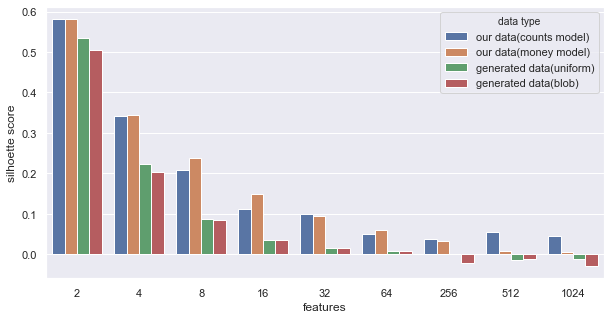

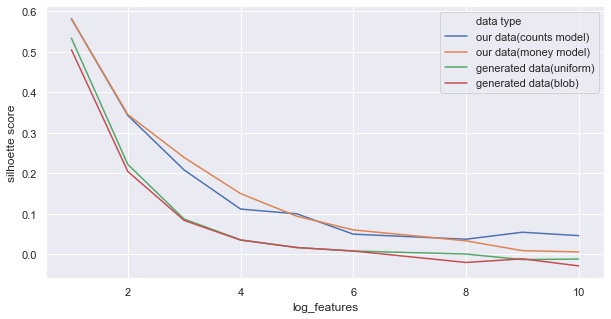

In [60]:
var = np.var(X_small,axis=0).argsort()
var2 = np.var(X_small_price,axis=0).argsort()
d = []
for n_features in [2,4,8,16,32,64,256,512,1024]:
    top_features = var[0, -n_features:].tolist()[0]
    new_X = X_small[:, top_features]
    new_X = normalize(new_X, axis=1)
    clf.fit(new_X)
    y = clf.predict(new_X)
    s = silhouette_score(new_X, y)
    #print(n_features, s)
    d.append([n_features, np.log2(n_features), s, 'our data(counts model)'])
    
    top_features = var2[0, -n_features:].tolist()[0]
    new_X = X_small_price[:, top_features]
    new_X = normalize(new_X, axis=1)
    clf.fit(new_X)
    y = clf.predict(new_X)
    s = silhouette_score(new_X, y)
    #print(n_features, s)
    d.append([n_features, np.log2(n_features), s, 'our data(money model)'])
    
    new_X = np.random.rand(10000, n_features)
    new_X = normalize(new_X, axis=1)
    clf.fit(new_X)
    y = clf.predict(new_X)
    s = silhouette_score(new_X, y)
    #print(n_features, s)
    d.append([n_features, np.log2(n_features), s, 'generated data(uniform)'])
    
    new_X = make_blobs(10000, n_features, centers=1)[0]
    new_X = normalize(new_X, axis=1)
    clf.fit(new_X)
    y = clf.predict(new_X)
    s = silhouette_score(new_X, y)
    #print(n_features, s)
    d.append([n_features, np.log2(n_features), s, 'generated data(blob)'])
df = pd.DataFrame(d, columns=['features', 'log_features', 'silhoette score', 'data type'])
plt.figure(figsize=(10, 5))
p = sns.barplot(data=df, x='features', y='silhoette score', hue='data type')
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x='log_features', y='silhoette score', hue='data type')


In [98]:
X, i_t_n, clf, importance_matrix = run_experiment(vectors, [1,2,3, 4], idf_function=lambda x: 1/x)
viz_clustering(X, i_t_n, clf)

113 matrix_created
117 classifier trained
cluster 1
coverage 0.2467789309174571


cluster 4
coverage 0.22736901777005433


Average user
coverage 0.18975473415159133


Average user(50 features)
coverage 0.26827662165301064


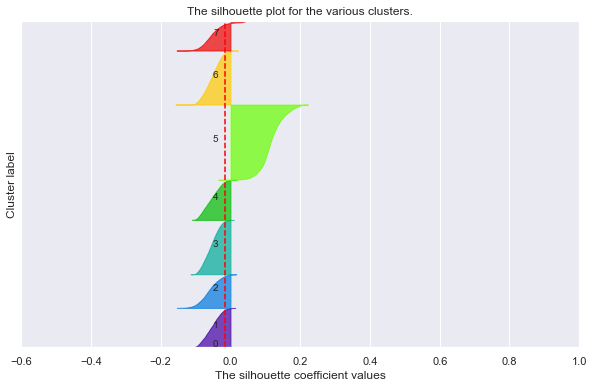

In [117]:
def viz_silhoette(X, clf, n_clusters=8):
    cluster_labels = clf.predict(X)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    #clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    f, ax1 = plt.subplots(1,1, figsize=(10,6))
    ax1.set_xlim([-0.6, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    y_lower = 10
    n_clusters=8
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=np.mean(sample_silhouette_values), color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    _ = ax1.set_xticks([-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

In [112]:
sample_silhouette_values

array([-0.05178851, -0.07328926, -0.07339481, ..., -0.03337964,
       -0.01871506, -0.07187414])

120 matrix_created
124 classifier trained


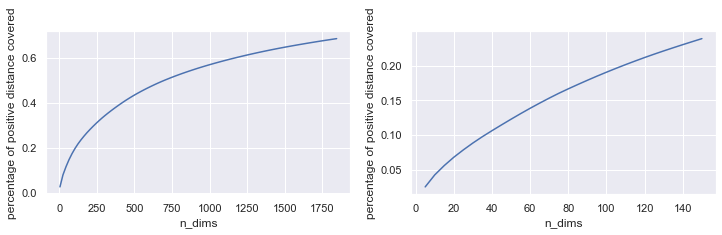

For cluster "0" with 5363 users 10 most important dimensions are:
 מזון 0.19 level: 0
יוגורט 0.18 level: 2
יוגורט לבן 0.18 level: 3
חלב טרי קרטון\כד עד 1 ליטר 0.16 level: 3
מוצרי חלב ותחליפיו 0.16 level: 1
שימורים 0.14 level: 1
שימורי עגבניות 0.13 level: 2
לחם ארוז מיוחד 0.11 level: 2
רסק עגבניות 0.1 level: 3
ביצים רגילות 12 יח 0.1 level: 3
For cluster "1" with 11487 users 10 most important dimensions are:
 משקאות קלים 0.17 level: 2
חטיפי חיטה 0.17 level: 3
משק"ל משפחתי 1ל ומעלה 0.17 level: 3
חטיפים 0.15 level: 2
חטיפים מלוחים 0.14 level: 1
חטיפי בוטנים 0.13 level: 3
חטיפים מלוחים לילדים 0.13 level: 3
חטיף תירס קונוס 0.13 level: 3
משקה קולה רגיל 0.12 level: 2
משקאות מוגזים טעמי פירות 0.12 level: 2
For cluster "2" with 8588 users 10 most important dimensions are:
 חטיפי דגנים מבוגרים 0.13 level: 2
חטיפי דגנים מבוגרים מארז 0.13 level: 3
יוגורט לבן 0.13 level: 3
יוגורט 0.12 level: 2
חלב טרי קרטון\כד עד 1 ליטר 0.12 level: 3
גבינות מלוחות מדף 0.12 level: 2
תחליפי לחם לנשנוש 0.11 level: 3
יר

In [61]:
X, i_t_n, clf, importance_matrix = run_experiment(vectors, [0, 1,2,3,4])

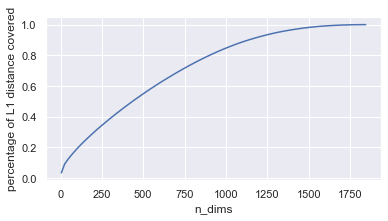

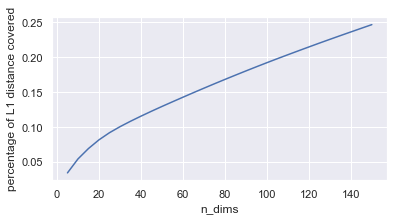

In [22]:

clf = KMeans(n_clusters=8, tol=0.01, random_state=1)
clf.fit(data_matrix)
clusters_matrix = np.array(clf.cluster_centers_)
clusters_matrix.shape
#print('Sum of L1 distances to other clusters from cluster 1 is', importance_matrix)


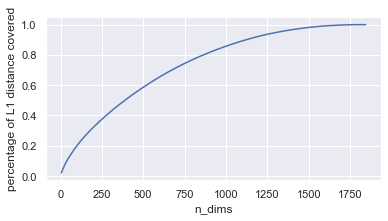

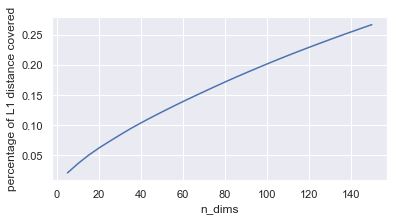

In [46]:
importance_matrix = np.zeros((8, 1853))
for i in range(8):
    for j in range(1853):
        importance_matrix[i,j] = np.maximum(clusters_matrix[i, j] - clusters_matrix[:,j], 0).sum()
total = importance_matrix[0, :].sum()
sorted_arr = np.sort(importance_matrix[0, :])
to_plot = []
for i in range(5, 1850, 20):
    to_plot.append([i, sum(sorted_arr[-i:])/total])
plt.figure(figsize=(6,3))
p = sns.lineplot(data=pd.DataFrame(to_plot, columns=['n_dims', 'percentage of L1 distance covered']), x='n_dims', y='percentage of L1 distance covered', markers=True)
plt.show()
to_plot = []
for i in range(5, 151, 5):
    to_plot.append([i, sum(sorted_arr[-i:])/total])
plt.figure(figsize=(6,3))
p = sns.lineplot(data=pd.DataFrame(to_plot, columns=['n_dims', 'percentage of L1 distance covered']), x='n_dims', y='percentage of L1 distance covered', markers=True)

In [48]:
predicted = clf.predict(data_matrix)
cnt = Counter(predicted)
for i in range(8):
    indices = importance_matrix[i, :].argsort()[-10:][::-1]
    #print(indices, importance_matrix[i, indices])
    print('For cluster "{}" with {} users 10 most important dimensions are:\n'.format(i, cnt[i]), '\n'.join([index_to_name[x][2:] +  ' ' + str(importance_matrix[i, x].round(2)) for x in indices]))

For cluster "0" with 10282 users 10 most important dimensions are:
 חלב טרי שקית 0.08
משקאות לבן 0.07
בירה לבנה בודד 0.05
אשל 0.04
יוגורט לבן 0.04
בירה לבנה בקבוק חוזר 0.04
בירה לבנה ב"ח 0.04
מעדן גבינה מוקצף 0.04
בירה לבנה בודד בקבוק 500 מ"ל 0.04
שוקולד מריר 70%+ פרימיום 0.04
For cluster "1" with 9326 users 10 most important dimensions are:
 משקה אנרגיה 0.31
משקאות פונקציונלים/קפה 0.28
תבשיל אישי 0.12
מעדן גלי 0.11
משקאות מוגזים טעמי פירות 0.11
תוסס משפחתי טעמי פירות 1ל ומעלה 0.11
משקה קולה רגיל מארז משפחתי 0.1
משקה קולה רגיל אישי 0.1
מעדן גבינה מוקצף 0.09
תבשילים ותערובות 0.09
For cluster "2" with 5866 users 10 most important dimensions are:
 משקה אנרגיה 0.19
משקאות פונקציונלים/קפה 0.17
מעדן גלי 0.16
יוגורט לבן דיאט 0.15
מעדני חלב דיאט 0.14
משקה דיאט קולה אישי 0.13
יוגורט ומעדני סויה וטופו 0.12
תבשיל אישי 0.12
חלב טרי שקית 0.12
אשל 0.12
For cluster "3" with 8871 users 10 most important dimensions are:
 תבלינים ורטבים קפואים 0.12
חומרים למדיח 0.11
עלי חסה שטוף 0.11
לקט לסלט 0.1
גבינות